# Aprendizaje de máquina - Proyecto final (Continuación)

**Continuación del análisis del notebook**: [FIFA2026.ipynb](FIFA2026.ipynb)

Modificamos el **objetivo**, de modo que ahora se plantea predecir el resultado de los partidos por victoria vs no victoria del local (win, no win).

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_fscore_support, precision_recall_curve

##### 1) EDA: Comprensión inicial del dataset, estadísticas descriptivas, identificación de variables, visualizaciones para entender distribuciones, correlaciones y posibles problemas como valores nulos o atípico.

Dado que ya se hizo el EDA en el notebook [FIFA2026.ipynb](FIFA2026.ipynb), vamos a limitarnos a lo mínimo indispensable para el caso de win vs no win

In [20]:
results = pd.read_csv("./archive/results.csv")
#results["date"] = pd.to_datetime(results["date"])
results["date"] = pd.to_datetime(results["date"], format="mixed", dayfirst=True, errors="coerce")

Vemos si el dataset contiene valores nulos y duplicados:

Como el dataset original no tiene la variable a predecir, se procede a crearla junto a otras variables utiles para visualizaciones

In [21]:
results["year"] = results["date"].dt.year
results["month"] = results["date"].dt.month
results["dayofweek"] = results["date"].dt.dayofweek
results["is_weekend"] = results["dayofweek"].apply(lambda x: 1 if x >= 5 else 0)

results["goal_diff"] = abs(results["home_score"] - results["away_score"])
results["total_score"] = results["home_score"] + results["away_score"]

results["result"] = results.apply(
    lambda row: "win" if row["home_score"] > row["away_score"] else "nowin",
    axis=1)

results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,dayofweek,is_weekend,goal_diff,total_score,result
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,1872,11,5,1,0,0,nowin
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,1873,3,5,1,2,6,win
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,1874,3,5,1,1,3,win
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,1875,3,5,1,0,4,nowin
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,1876,3,5,1,3,3,win


Veamos la distribución del target

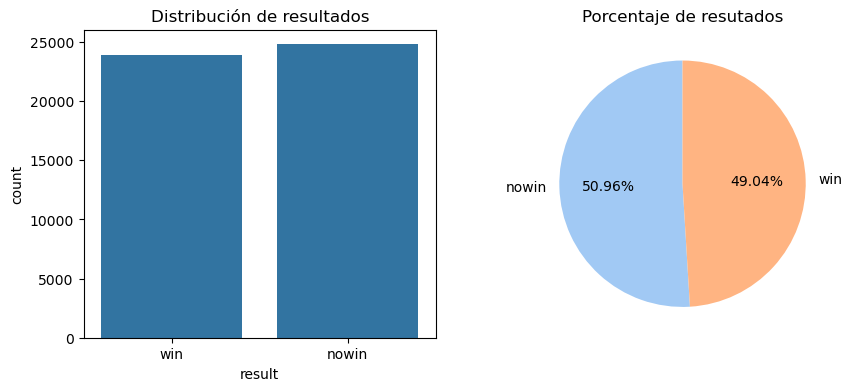

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(data=results, x="result", order=["win","nowin"], ax=ax[0])
ax[0].set_title("Distribución de resultados")

results_counts = results['result'].value_counts()
ax[1].pie(results_counts, labels=results_counts.index, autopct='%1.2f%%', startangle=90, colors=sns.color_palette('pastel'))
ax[1].set_title('Porcentaje de resutados')

plt.show()

📝 A partir de los graficos de los resultados, vemos una gran mejora en el balance en las clases. Se podría decir que el dataset queda balanceado en relación al target.

 ##### 2) Preprocesamiento y Preparación de Datos: Descripción de las transformaciones aplicadas a los datos para prepararlos para el modelado. Esto incluye, pero no se limita a: limpieza de datos, imputación de valores faltantes, codificación de variables categóricas, escalado de características, etc.

📝 Igual que en el anterior, vamos a basarnos en el rating elo de los dos equipos y la diferencia entre ambos.

Para más detalles sobre el funcionamiento del sistema Elo y su aplicación en el ranking de equipos: [World Football Elo Ratings](https://en.wikipedia.org/wiki/World_Football_Elo_Ratings).

En este proyecto se asigna un valor inicial (1500) a cada equipo y se aplica un factor de ajuste (K = 20) para actualizar los ratings tras cada partido, considerando además una ventaja local de 80 puntos. De esta manera se puede usar la función "compute_elo_features". para obtener la diferencia de ratings entre el equipo local y el equipo visitante.

In [78]:
# Cálculo de ELO con 1/2 año de half-life y N_prev=10

from collections import deque
from math import log

# Parámetros 
R0 = 1500.0
K_base = 20.0
HOME_ADV = 80.0           # ventaja local en puntos ELO
half_life_years = 2.0     # half-life (0.5 parece el mejor valor)
half_life_days  = 365.0 * half_life_years
N_prev = 20               # ← cantidad de partidos “hacia atrás” por equipo

# Pesos por torneo (ajustables). Default = 1.1 como pediste.
weights = {
    "FIFA World Cup": 1.6,
    "UEFA European Championship": 1.4,
    "Copa América": 1.4,
    "FIFA World Cup qualification": 1.3,
    "UEFA Nations League": 1.2,
}
#    "Friendly": 0.9,

def w_tournament(t):
    return weights.get(t, 1.1)  # ← default sensato

def elo_expect(Ra, Rb, home_adv):
    return 1.0 / (1.0 + 10.0 ** ((Rb - (Ra + home_adv)) / 400.0))

def compute_elo_features(df):
    """Calcula ELO de forma cronológica."""
    ratings, last_played, recent_counts = {}, {}, {}
    snapshots = []

    df = df.sort_values("date").copy()
    for _, row in df.iterrows():
        d, ht, at = row["date"], row["home_team"], row["away_team"]
        hs, as_, tour, neut = row["home_score"], row["away_score"], row["tournament"], bool(row["neutral"])

        for team in (ht, at):
            if team not in ratings: ratings[team] = R0
            if team not in recent_counts: recent_counts[team] = deque(maxlen=N_prev)
            if team in last_played:
                delta_days = (d - last_played[team]).days
                if delta_days > 0:
                    decay = 0.5 ** (delta_days / half_life_days)
                    ratings[team] = R0 + (ratings[team] - R0) * decay

        Rh_pre, Ra_pre = ratings[ht], ratings[at]  # ratings antes del partido
        home_adv = 0 if neut else HOME_ADV
        Eh = elo_expect(Rh_pre, Ra_pre, home_adv)
        Ea = 1 - Eh

        # Resultado
        if hs > as_: Sh, Sa = 1, 0
        elif hs < as_: Sh, Sa = 0, 1
        else: Sh, Sa = 0.5, 0.5

        margin = max(1, log(1 + abs(hs - as_), 2))
        Kw_base = K_base * w_tournament(tour) * margin
        cnt_h, cnt_a = len(recent_counts[ht]), len(recent_counts[at])
        factor_h, factor_a = min(1, cnt_h / N_prev), min(1, cnt_a / N_prev)
        Kw_h, Kw_a = Kw_base * (0.5 + 0.5 * factor_h), Kw_base * (0.5 + 0.5 * factor_a)

        # Actualizamos después del partido
        ratings[ht] = Rh_pre + Kw_h * (Sh - Eh)
        ratings[at] = Ra_pre + Kw_a * (Sa - Ea)

        recent_counts[ht].append(d)
        recent_counts[at].append(d)
        last_played[ht], last_played[at] = d, d

        # Guardamos el snapshot usando los ratings previos al partido
        snapshots.append({
            "date": d,
            "home_team": ht,
            "away_team": at,
            "home_rating": Rh_pre,
            "away_rating": Ra_pre
        })

    elo_df = pd.DataFrame(snapshots)
    elo_df["rating_diff"] = elo_df["home_rating"] - elo_df["away_rating"]
    return elo_df

📝 En base al analisis previo, se decide filtrar los datos a partir de 1920. Antes de esa fecha, había más diferencia entre los equipos (mayor diferencia de goles).

Otros filtros a considerar que podrían introducir ruido en el modelo:
* Cardinalidad de los torneos: existen demasiados torneos por lo cual podría ser conveniente centrarse en los mas conocidos.

También creamos la variable target {1: "win", 0: "nowin"} y las variables
Y creamos nuevas features a partir de la fecha.

📝 Como el objetivo es predecir el resultado del partido, no podemos usar los registros como tal ya que estos son posteriores al partido. Por lo tanto, se crean la variable elo_df que representa la diferencia en el rendimiento de los equipos en los últimos partidos jugados, y de esta forma evitamos el *data leakage*.

In [79]:
# Filtrado de datos desde 1920 y Friendly removidos

ANIO_MIN = 1920
EXCLUIR_TORNEOS = ["Friendly"]  # Agregar aquí los torneos que se desee filtrar

results_filtered = results[
    (results["date"].dt.year >= ANIO_MIN) &
    (~results["tournament"].isin(EXCLUIR_TORNEOS))
].copy()

print("Original", results.shape)
print("Filtrado", results_filtered.shape)

# Nuevas features
results_filtered["goal_diff"] = results_filtered["home_score"] - results_filtered["away_score"]

results_filtered["target"] = np.where(results_filtered["goal_diff"] > 0, 1, 0)

results_filtered["year"] = results_filtered["date"].dt.year
results_filtered["month"] = results_filtered["date"].dt.month
results_filtered["dayofweek"] = results_filtered["date"].dt.dayofweek
results_filtered["neutral"] = results_filtered["neutral"].astype(int)

# Calcular ELO
elo_df = compute_elo_features(results_filtered)
results_with_rating = results_filtered.merge(
    elo_df, on=["date", "home_team", "away_team"], how="left"
)

Original (48673, 16)
Filtrado (30209, 16)


In [80]:
print("Nulos en base al procesamiento:\n", results_filtered.isna().sum()[results_filtered.isna().sum() > 0])

Nulos en base al procesamiento:
 Series([], dtype: int64)


No aparecen valores nulos después de los cálculos.

Hacemos el split del dataset y codificamos las variables categoricas:
- year, month y dayofweek ya se codificaron mediante cycling encoding pero no tuvieron peso en relación a las predicciones.
- home_team, away_team, tournament se codifican con TargetEncoder por tener una cardinalidad alta

Finalmente, se estandarizan las variables para que todas tengan la misma escala.

In [81]:
results_filtered.tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,dayofweek,is_weekend,goal_diff,total_score,result,target
48668,2025-10-14,Republic of Ireland,Armenia,1,0,FIFA World Cup qualification,Dublin,Republic of Ireland,0,2025,10,1,0,1,1,win,1
48669,2025-10-14,Estonia,Moldova,1,1,FIFA World Cup qualification,Tallinn,Estonia,0,2025,10,1,0,0,2,nowin,0
48670,2025-10-14,Italy,Israel,3,0,FIFA World Cup qualification,Udine,Italy,0,2025,10,1,0,3,3,win,1
48671,2025-10-14,Andorra,Serbia,1,3,FIFA World Cup qualification,Encamp,Andorra,0,2025,10,1,0,-2,4,nowin,0
48672,2025-10-14,Latvia,England,0,5,FIFA World Cup qualification,Riga,Latvia,0,2025,10,1,0,-5,5,nowin,0


In [82]:

# Features
feat_cat = ["home_team", "away_team", "tournament"]
feat_num = ["neutral", "year", "month", "dayofweek", "rating_diff"]

X = results_with_rating[feat_cat + feat_num]
y = results_with_rating["target"]

X.tail()

,home_team,away_team,tournament,neutral,year,month,dayofweek,rating_diff
30206,Republic of Ireland,Armenia,FIFA World Cup qualification,0,2025,10,1,71.898970
30207,Estonia,Moldova,FIFA World Cup qualification,0,2025,10,1,-13.066711
30208,Italy,Israel,FIFA World Cup qualification,0,2025,10,1,91.100549
30209,Andorra,Serbia,FIFA World Cup qualification,0,2025,10,1,-154.512778
30210,Latvia,England,FIFA World Cup qualification,0,2025,10,1,-284.327334


In [83]:

# Split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Codificacion y standarización
pre = ColumnTransformer(
    transformers=[
        
        ("home_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["home_team"]),
        ("away_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["away_team"]),
        ("tour_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["tournament"]),
        ("num", StandardScaler(), feat_num)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)


##### 3) Modelado: Construcción y entrenamiento de los modelos de aprendizaje automático.

📝 Para modelar el problema, se van a utilizar diferentes algoritmos de clasificación para hacer un analisis comparativo y ver cual se adapta mejor al problema.


Top 10 importancias:
home_team      4.154503
away_team      3.997599
tournament     2.459237
rating_diff    0.544580
neutral        0.197520
year           0.090786
dayofweek      0.009456
month          0.007980
dtype: float64


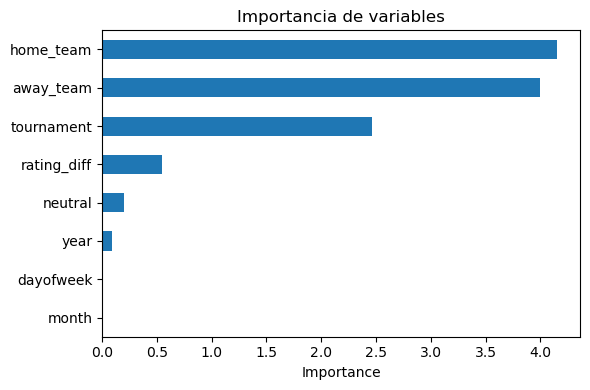

In [84]:
# Logistic Regression

clf = Pipeline(steps=[
    ("pre", pre),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

# Fit
clf.fit(X_tr, y_tr)

# Predicciones
y_pred_logreg = clf.predict(X_te)
y_proba_logreg = clf.predict_proba(X_te)

# Importancia de features
try:
    feature_names = clf.named_steps["pre"].get_feature_names_out()
except Exception:
    feature_names = np.array(["home_team_TE","away_team_TE","tournament_TE"] + feat_num)

importances = pd.Series(np.mean(np.abs(clf.named_steps["model"].coef_), axis=0), index=feature_names).sort_values(ascending=False)

print("\nTop 10 importancias:")
print(importances.head(10))

plt.figure(figsize=(6,4))
importances.head(10).sort_values().plot(kind="barh")
plt.title("Importancia de variables")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [85]:
# KNN

clf = Pipeline(steps=[
    ("pre", pre),
    ("model", KNeighborsClassifier(
        n_neighbors=21, metric="minkowski", p=2
    ))
])

# Fit
clf.fit(X_tr, y_tr)

# Predicciones
y_pred_knn = clf.predict(X_te)
y_proba_knn = clf.predict_proba(X_te)

In [86]:
# SVM

clf = Pipeline(steps=[
    ("pre", pre),
    ("model", SVC(C=5, kernel="rbf", decision_function_shape='ovr', probability=True))
])

# Fit
clf.fit(X_tr, y_tr)

# Predicciones
y_pred_svm = clf.predict(X_te)
y_proba_svm = clf.predict_proba(X_te)

In [87]:
# Arbol de decisión

clf = Pipeline(steps=[
    ("pre", pre),
    ("model", DecisionTreeClassifier(
        criterion='entropy', 
        splitter='best', 
        max_depth=10,
        min_samples_split=8,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42)
    )
])

# Fit
clf.fit(X_tr, y_tr)

# Predicciones
y_pred_dtc = clf.predict(X_te)
y_proba_dtc = clf.predict_proba(X_te)

In [88]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=15, 
                             min_samples_split=8, min_samples_leaf=3, 
                             class_weight='balanced', random_state=42)
clf = Pipeline(steps=[
    ("pre", pre),
    ("model", RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=15, 
                             min_samples_split=8, min_samples_leaf=3, 
                             class_weight='balanced', random_state=42)
    )
])

# Fit
clf.fit(X_tr, y_tr)

# Predicciones
y_pred_rfc = clf.predict(X_te)
y_proba_rfc = clf.predict_proba(X_te)

##### 4) Evaluación de Resultados: Análisis cuantitativo y cualitativo del rendimiento de los modelos utilizando métricas apropiadas. Se deben interpretar los resultados en el contexto del problema original.

In [89]:
# Funcion para imprimir resultados de clasificación
def print_classification_results(y_test, y_pred, model_name):
    print(f"\nResultados para {model_name}:")

    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))

    print("\nClassification Report:\n", 
          classification_report(y_test, y_pred, 
                              target_names=["nowin", "win"],
                              zero_division=0))
    plot_normalized_confusion(y_test, y_pred)
    
def plot_normalized_confusion(y_true, y_pred, labels=["nowin", "win"],
                              title="Matriz de confusión", figsize=(4.5, 4)):
    # Matriz de confusión normalizada
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plt.figure(figsize=figsize)
    disp.plot(values_format=".2f", cmap=None, colorbar=False)
    plt.title(title)
    plt.show()

📝 En el contexto de este problema, queremos que el modelo prediga las clases del resultado por igual. Por lo que nos vamos a enfocar en la métrica de accuracy, pero como existe un desbalance en las clases, también se va a considerar la métrica de F1-score global y log loss.


Resultados para Regresión Logística:

Accuracy: 0.7052788350157206
F1-score (macro): 0.7052497779702385

Classification Report:
               precision    recall  f1-score   support

       nowin       0.71      0.70      0.70      3019
         win       0.70      0.71      0.71      3024

    accuracy                           0.71      6043
   macro avg       0.71      0.71      0.71      6043
weighted avg       0.71      0.71      0.71      6043



<Figure size 450x400 with 0 Axes>

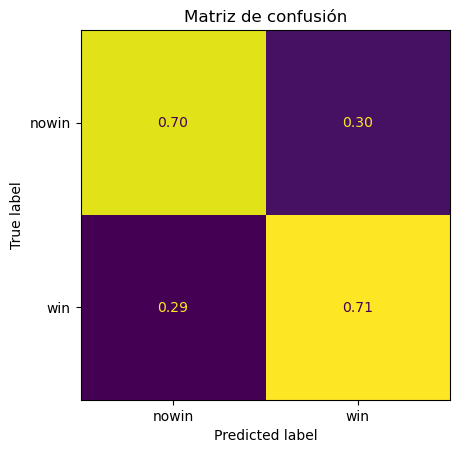


Resultados para KNN:

Accuracy: 0.6786364388548735
F1-score (macro): 0.6785920710343614

Classification Report:
               precision    recall  f1-score   support

       nowin       0.68      0.67      0.67      3019
         win       0.68      0.69      0.68      3024

    accuracy                           0.68      6043
   macro avg       0.68      0.68      0.68      6043
weighted avg       0.68      0.68      0.68      6043



<Figure size 450x400 with 0 Axes>

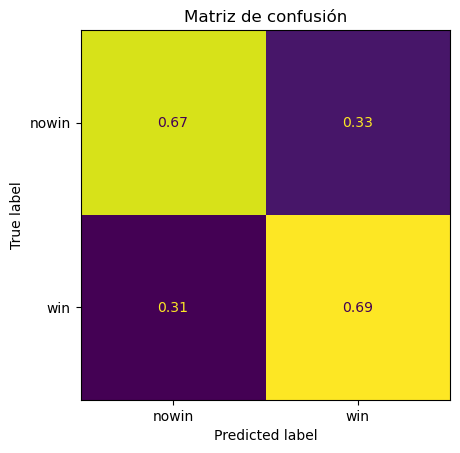


Resultados para SVC:

Accuracy: 0.7057752771802085
F1-score (macro): 0.7057717239953065

Classification Report:
               precision    recall  f1-score   support

       nowin       0.71      0.70      0.70      3019
         win       0.70      0.71      0.71      3024

    accuracy                           0.71      6043
   macro avg       0.71      0.71      0.71      6043
weighted avg       0.71      0.71      0.71      6043



<Figure size 450x400 with 0 Axes>

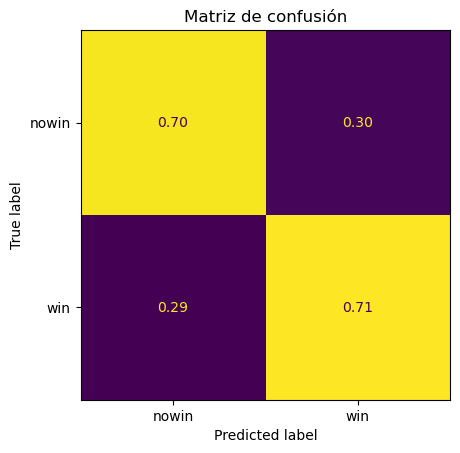


Resultados para Árbol de Decisión:

Accuracy: 0.6887307628661261
F1-score (macro): 0.6886079723589954

Classification Report:
               precision    recall  f1-score   support

       nowin       0.70      0.67      0.68      3019
         win       0.68      0.71      0.69      3024

    accuracy                           0.69      6043
   macro avg       0.69      0.69      0.69      6043
weighted avg       0.69      0.69      0.69      6043



<Figure size 450x400 with 0 Axes>

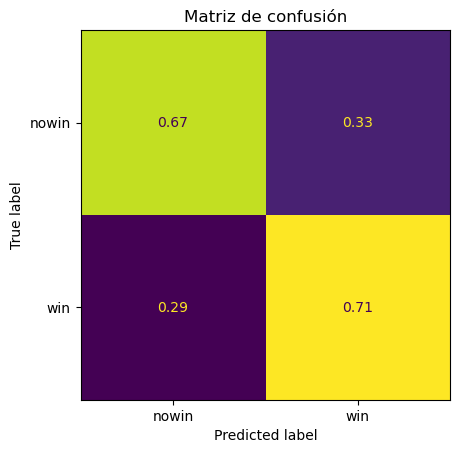


Resultados para Random Forest:

Accuracy: 0.7099122952176071
F1-score (macro): 0.7099097214282731

Classification Report:
               precision    recall  f1-score   support

       nowin       0.71      0.71      0.71      3019
         win       0.71      0.71      0.71      3024

    accuracy                           0.71      6043
   macro avg       0.71      0.71      0.71      6043
weighted avg       0.71      0.71      0.71      6043



<Figure size 450x400 with 0 Axes>

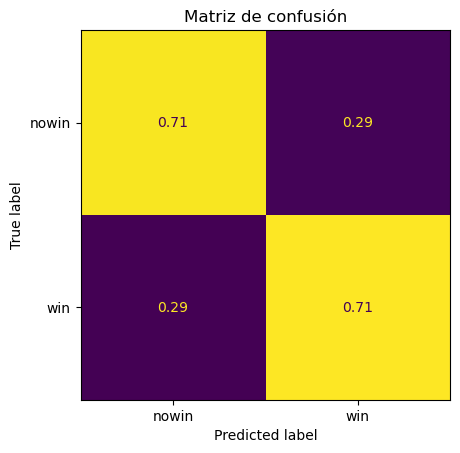

In [90]:
print_classification_results(y_te, y_pred_logreg, "Regresión Logística")
print_classification_results(y_te, y_pred_knn, "KNN")
print_classification_results(y_te, y_pred_svm, "SVC")
print_classification_results(y_te, y_pred_dtc, "Árbol de Decisión")
print_classification_results(y_te, y_pred_rfc, "Random Forest")

(win vs no-win) @thr=0.50
Accuracy : 0.710
Precision: 0.709
Recall   : 0.712
F1       : 0.711
ROC-AUC  : 0.777

Mejor umbral por F1
thr          0.330
accuracy     0.670
precision    0.617
recall       0.896
f1           0.731
Name: 3, dtype: float64


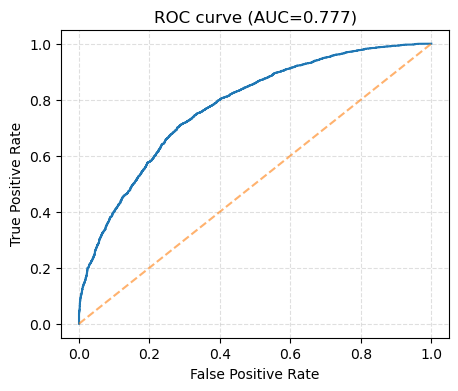

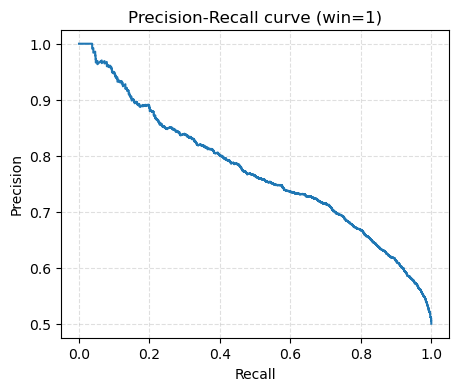


BINARIO @thr=0.40 (óptimo por F1)
Accuracy : 0.692
Precision: 0.650
Recall   : 0.829
F1       : 0.729


In [91]:
# clf es ahora Random Forest
p_win = clf.predict_proba(X_te)[:, 1]  # prob de win
y_pred05 = (p_win >= 0.5).astype(int)

acc = accuracy_score(y_te, y_pred05)
prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_pred05, average="binary", zero_division=0)
auc = roc_auc_score(y_te, p_win)

print("(win vs no-win) @thr=0.50")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1       : {f1:.3f}")
print(f"ROC-AUC  : {auc:.3f}")

# Buscar mejor umbral por F1
ths = np.linspace(0.3, 0.7, 41)  # barrido fino
rows = []
for t in ths:
    y_hat = (p_win >= t).astype(int)
    acc_t = accuracy_score(y_te, y_hat)
    prec_t, rec_t, f1_t, _ = precision_recall_fscore_support(y_te, y_hat, average="binary", zero_division=0)
    rows.append({"thr": t, "accuracy": acc_t, "precision": prec_t, "recall": rec_t, "f1": f1_t})
scan = pd.DataFrame(rows)
best = scan.sort_values("f1", ascending=False).iloc[0]
print("\nMejor umbral por F1")
print(best.round(3))

# Curvas ROC y PR
fpr, tpr, _ = roc_curve(y_te, p_win)
pr, rc, _ = precision_recall_curve(y_te, p_win)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC curve (AUC={auc:.3f})")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

plt.figure(figsize=(5,4))
plt.plot(rc, pr)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve (win=1)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

thr_bin = 0.40   # binario

# Predicción con umbral óptimo
y_pred_opt = (p_win >= thr_bin).astype(int)
acc_o = accuracy_score(y_te, y_pred_opt)
prec_o, rec_o, f1_o, _ = precision_recall_fscore_support(y_te, y_pred_opt, average="binary", zero_division=0)
print(f"\nBINARIO @thr={thr_bin:.2f} (óptimo por F1)")
print(f"Accuracy : {acc_o:.3f}")
print(f"Precision: {prec_o:.3f}")
print(f"Recall   : {rec_o:.3f}")
print(f"F1       : {f1_o:.3f}")

---

📝 Se obtuvieron mejores resultados